In [1]:
import pandas as pd
from tabulate import tabulate
import kagglehub
import os
from zipfile import ZipFile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.2f}'.format)


## Data Load

### About Dataset


This dataset captures real-world salary data for jobs in Data Science, Artificial Intelligence, and Machine Learning from 2020 to 2025. Each row represents a reported salary, enriched with attributes like job title, experience level, company size, remote work ratio, and geographic context. This data is valuable for analyzing salary trends over time, comparing roles across countries, and exploring compensation based on experience, work setting, and more.

[Link to datasource](https://www.kaggle.com/datasets/adilshamim8/salaries-for-data-science-jobs)

Column Descriptions:

- work_year:The year the salary was reported. Covers salaries from 2020 through 2025.

- experience_level:The seniority level of the employee at the time of reporting. Common values include:

- EN: Entry-level / Junior
- MI: Mid-level / Intermediate
- SE: Senior-level
- EX: Executive / Director

employment_type


- FT: Full-time
- PT: Part-time
- CT: Contract
- FL: Freelance
- job_title

- salary: The employee's gross annual salary in the original reported currency, before taxes and deductions.

- salary_currency :The currency in which the salary was originally paid (e.g., USD, EUR, INR).

- salary_in_usd: The employee's salary converted into USD using 2025 exchange rates for standardized comparison.

- employee_residence:The country (ISO 3166-1 alpha-2 code) where the employee resides. This may differ from the company location, especially in remote roles.

- remote_ratio:Indicates the percentage of remote work:

  - 0: No remote work (On-site)
  - 50: Hybrid (partially remote)
  - 100: Fully remote
  - company_location

company_size

- S: Small (1–50 employees)
- M: Medium (51–500 employees)
- L: Large (501+ employees)

In [2]:
# Step 1: Download the latest version of the dataset
path = kagglehub.dataset_download("adilshamim8/salaries-for-data-science-jobs")
# print("Path to dataset files:", path)


for file in os.listdir(path):
    if file.endswith(".zip"):
        zip_path = os.path.join(path, file)
        with ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(path)
        print(f"Extracted: {zip_path}")


file_name = "salaries.csv"
file_path = os.path.join(path, file_name)

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    # df.set_index('Date',inplace=True)
    print("DataFrame loaded successfully:")

else:
    print(f"{file_name} not found in the dataset folder.")

DataFrame loaded successfully:


### Make pandas more memory efficient
- Well, with small dataset it doesn't matter but with large dataset it does. 
- So, we will convert the data types of the columns to the most memory efficient type.

In [3]:
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [4]:
# convert datatypes to the most memory efficient type
def convert_dtypes(df):
    for col in df.columns:
        if pd.api.types.is_integer_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif pd.api.types.is_float_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif pd.api.types.is_object_dtype(df[col]):
            df[col] = df[col].astype('category')
    return df

# before and after memory usage
before_memory = df.memory_usage(deep=True).sum() / (1024 ** 2)  # in MB
df = convert_dtypes(df)
after_memory = df.memory_usage(deep=True).sum() / (1024 ** 2)  # in MB
print(f"Before: {before_memory:.2f} MB")
print(f"After: {after_memory:.2f} MB")



Before: 52.40 MB
After: 2.54 MB


## Univariate Analysis

### Summary Statistics

In [5]:
summary_stats = df.describe().T.round(2)  # Transpose + round for better format
summary_stats_categorical = df.describe(include=['category']).T
# summary_stats = summary_stats.applymap(lambda x: f"{x:,.2f}" if isinstance(x, (int, float)) else x)
print("\n📊 Summary Statistics for Numerical Columns:\n")
print(tabulate(summary_stats, headers='keys', tablefmt='fancy_grid'))
print("\n🔤 Summary Statistics for Categorical Columns:\n")
print(tabulate(summary_stats_categorical, headers='keys', tablefmt='fancy_grid'))



📊 Summary Statistics for Numerical Columns:

╒═══════════════╤═════════╤═══════════╤═══════════╤═══════╤════════╤════════╤════════╤═══════════════╕
│               │   count │      mean │       std │   min │    25% │    50% │    75% │           max │
╞═══════════════╪═════════╪═══════════╪═══════════╪═══════╪════════╪════════╪════════╪═══════════════╡
│ work_year     │  136757 │   2024.37 │      0.68 │  2020 │   2024 │   2024 │   2025 │   2025        │
├───────────────┼─────────┼───────────┼───────────┼───────┼────────┼────────┼────────┼───────────────┤
│ salary        │  136757 │ 163043    │ 215044    │ 14000 │ 106000 │ 147000 │ 198800 │      3.04e+07 │
├───────────────┼─────────┼───────────┼───────────┼───────┼────────┼────────┼────────┼───────────────┤
│ salary_in_usd │  136757 │ 157491    │  74173.6  │ 15000 │ 105900 │ 146000 │ 197800 │ 800000        │
├───────────────┼─────────┼───────────┼───────────┼───────┼────────┼────────┼────────┼───────────────┤
│ remote_ratio  │  136757 │


📈 Analyzing column: salary_in_usd
Mean: 157,490.72, Std: 74,173.55, Skew: 1.37


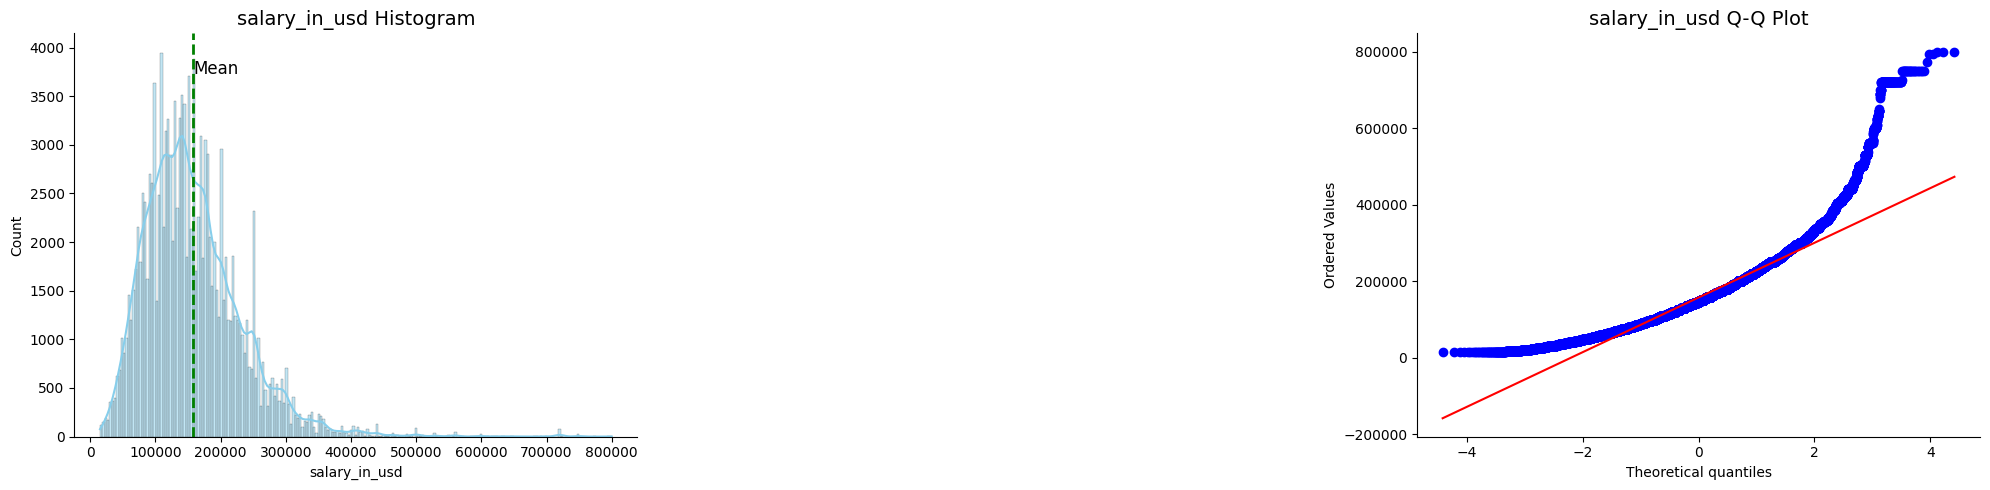

In [6]:
import scipy.stats as stats


# Optional: set global formatting
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# Identify numerical columns
num_cols = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col]) and col not in ['work_year','salary','remote_ratio']]

target_col = 'salary_in_usd'

for col in num_cols:
    print(f"\n📈 Analyzing column: {col}")
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # --- Histogram with KDE ---
    sns.histplot(df[col], ax=axes[0], kde=True, color='skyblue')
    mean_val = df[col].mean()
    axes[0].axvline(mean_val, color='green', linestyle='--', linewidth=2)
    axes[0].text(mean_val, axes[0].get_ylim()[1] * 0.9, "Mean", color='black', fontsize=12)
    axes[0].set_title(f'{col} Histogram', fontsize=14)

    if col != target_col:
        sns.regplot(x=df[col], y=df[target_col], ax=axes[1], scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
        axes[1].set_title(f'{col} vs {target_col}', fontsize=14)
    else:
        axes[1].axis('off')  # No scatter if it's the target

    # --- Q-Q plot ---
    stats.probplot(df[col], dist="norm", plot=axes[2])
    axes[2].set_title(f'{col} Q-Q Plot', fontsize=14)

    # --- Print basic stats ---
    std_val = df[col].std()
    skew_val = df[col].skew()
    print(f'Mean: {mean_val:,.2f}, Std: {std_val:,.2f}, Skew: {skew_val:,.2f}')

    plt.tight_layout()
    sns.despine()
    plt.show()


#### Insights:
- The distribution of `salary_in_usd` is slightly right-skewed as skewness = 1.37.
- This indicates the presence of outliers or extreme values in the target variable.

### Outliers Check:

Text(0.5, 1.0, 'Salary in USD Box Plot')

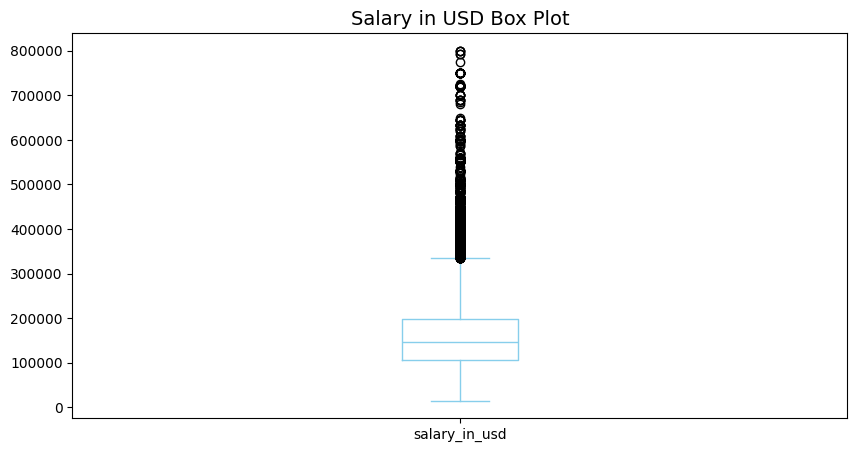

In [7]:
df['salary_in_usd'].plot(kind='box', figsize=(10, 5), color='skyblue')
plt.title('Salary in USD Box Plot', fontsize=14)

- There are someome outliers in the salary_in_usd column.

In [8]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,MI,FT,Data Scientist,132600,USD,132600,US,100,US,M
1,2025,MI,FT,Data Scientist,102000,USD,102000,US,100,US,M
2,2025,SE,FT,Data Product Manager,260520,USD,260520,US,0,US,M
3,2025,SE,FT,Data Product Manager,140280,USD,140280,US,0,US,M
4,2025,SE,FT,Machine Learning Engineer,215000,USD,215000,US,0,US,M


## Bivariateate Analysis

### Salary by Experience level

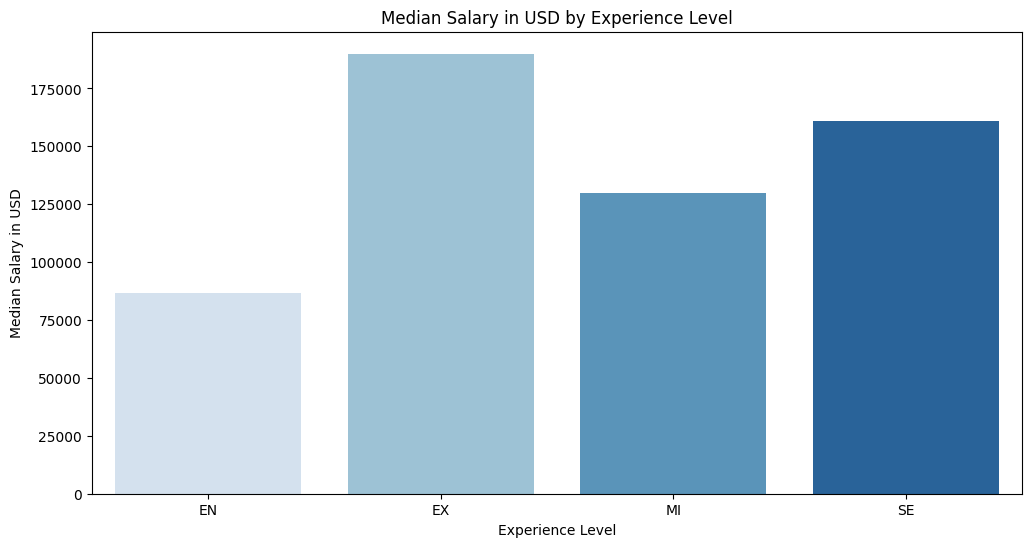

In [9]:

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='experience_level', y='salary_in_usd', estimator=np.median, ci=None, palette='Blues')

# Add title and labels
plt.title('Median Salary in USD by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Median Salary in USD')

# Add grid for better readability
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

#### Insights:
- Executives level are making highest median salary in USD.
- Senior Level is the second highest
> Median value  is selected as measure of central tendency because its robust to extreme values.

### Salary by residence

In [10]:

df.groupby("employee_residence")["salary_in_usd"].median().sort_values(ascending=False)

employee_residence
QA   300,000.00
CD   275,000.00
VE   192,500.00
US   151,232.50
SA   150,000.00
        ...    
HU    21,162.00
TW    19,284.00
EC    16,000.00
DO    16,000.00
SV    16,000.00
Name: salary_in_usd, Length: 102, dtype: float64

#### insights:



* **Top Salaries:** Qatar ($300,000) and Democratic Republic of the Congo ($275,000) offer the highest salaries.
* **Mid-Range Salaries:** The United States ($151,232), Saudi Arabia ($150,000), and Puerto Rico ($135,000) show mid-level compensation.
* **Lower-Range Salaries:** Salaries in People's Republic of China ($125,404), Switzerland ($122,638), New Zealand ($122,552), and Lebanon ($122,500) are clustered at the lower end of the spectrum.
* **Significant Geographic Impact:** Employee residence plays a substantial role in salary, with a wide range from $122,500 to $300,000 across countries.

### Salary by work status

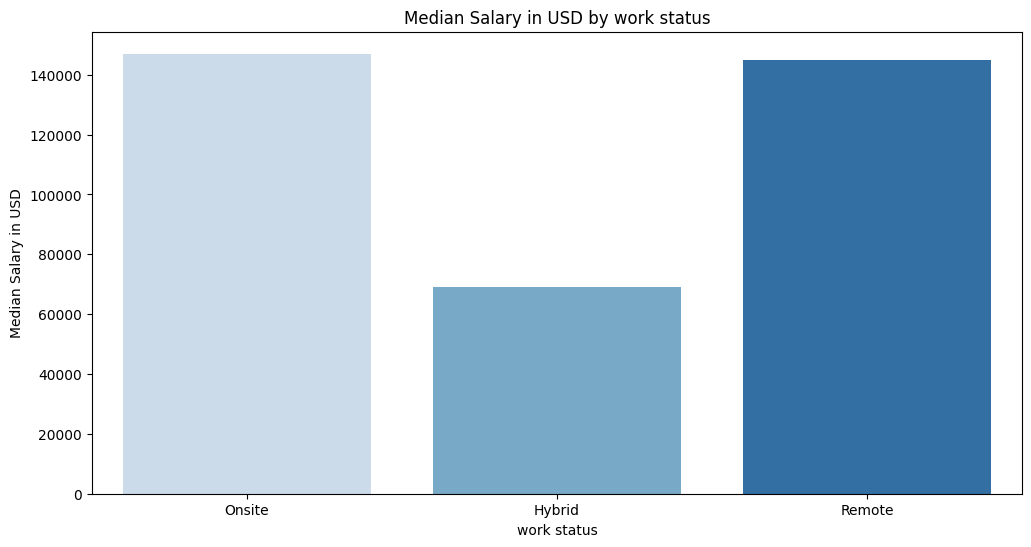

In [11]:
# change columns name and values inside the the columns
df.rename(columns={
    'remote_ratio': 'work_status'}, inplace=True)
df['work_status']  = df['work_status'].astype('category')
df['work_status'] = df['work_status'].replace({
    0: 'Onsite',
    50: 'Hybrid',
    100: 'Remote'
})


plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='work_status', y='salary_in_usd', estimator=np.median, ci=None, palette='Blues')

# Add title and labels
plt.title('Median Salary in USD by work status')
plt.xlabel('work status')
plt.ylabel('Median Salary in USD')

# Add grid for better readability
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

#### Insights:
- Median salary for remote and onsite is similar but `Onsite` is slightly higher.
- `Hybrid` work status has the lowest median salary.

In [12]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,work_status,company_location,company_size
0,2025,MI,FT,Data Scientist,132600,USD,132600,US,Remote,US,M
1,2025,MI,FT,Data Scientist,102000,USD,102000,US,Remote,US,M
2,2025,SE,FT,Data Product Manager,260520,USD,260520,US,Onsite,US,M
3,2025,SE,FT,Data Product Manager,140280,USD,140280,US,Onsite,US,M
4,2025,SE,FT,Machine Learning Engineer,215000,USD,215000,US,Onsite,US,M


### Salary Salary Over Years

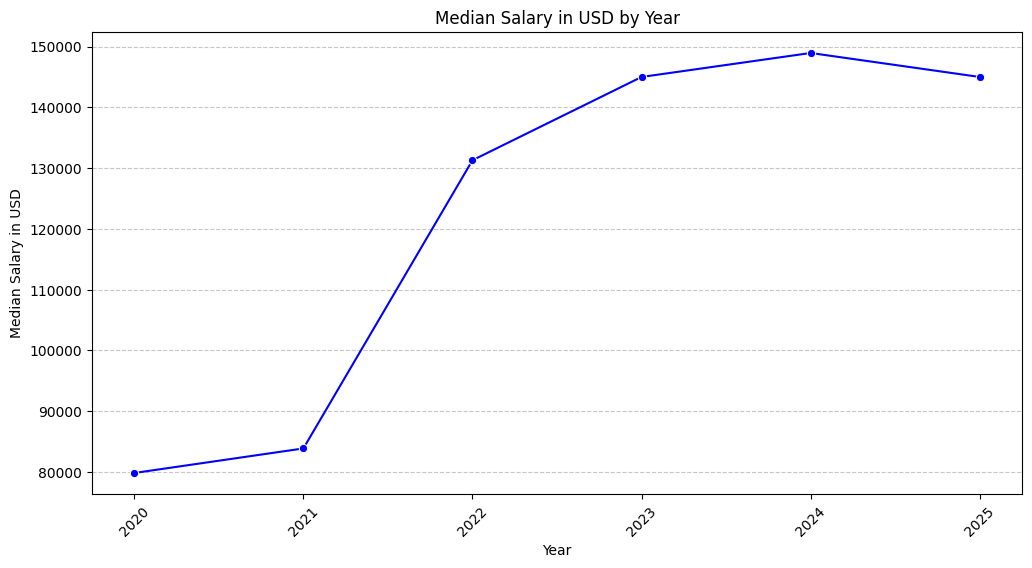

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='work_year', y='salary_in_usd', estimator=np.median, ci=None, marker='o', color='blue')
plt.title('Median Salary in USD by Year')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Median Salary in USD')
plt.xticks(rotation=45)
plt.show()


#### Insights:
 - A significant jump is observed in 2022, with median salary rising to about $131,000 — over a 60% increase compared to 2021.
 -  Salaries kept rising, reaching around $145,000 in 2023 and peaking near $149,000 in 2024.
 -  Median salary decreased a bit in 2025, falling back to roughly $145,000.
 -  The general trajectory from 2020 to 2025 shows strong upward movement in median salaries.

In [21]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,work_status,company_location,company_size
0,2025,MI,FT,Data Scientist,132600,USD,132600,US,Remote,US,M
1,2025,MI,FT,Data Scientist,102000,USD,102000,US,Remote,US,M
2,2025,SE,FT,Data Product Manager,260520,USD,260520,US,Onsite,US,M
3,2025,SE,FT,Data Product Manager,140280,USD,140280,US,Onsite,US,M
4,2025,SE,FT,Machine Learning Engineer,215000,USD,215000,US,Onsite,US,M


### Salary vs Categorical Features

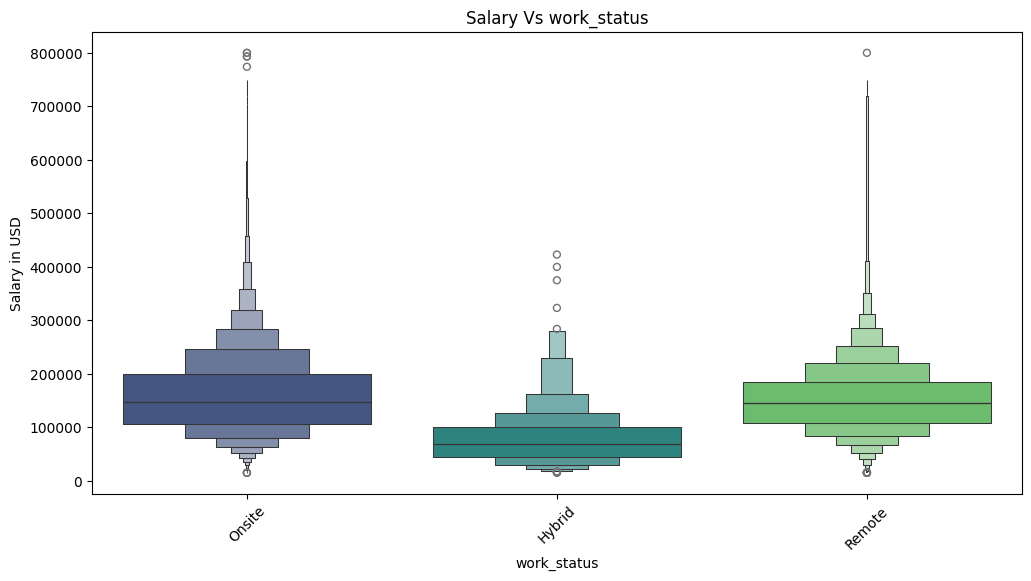

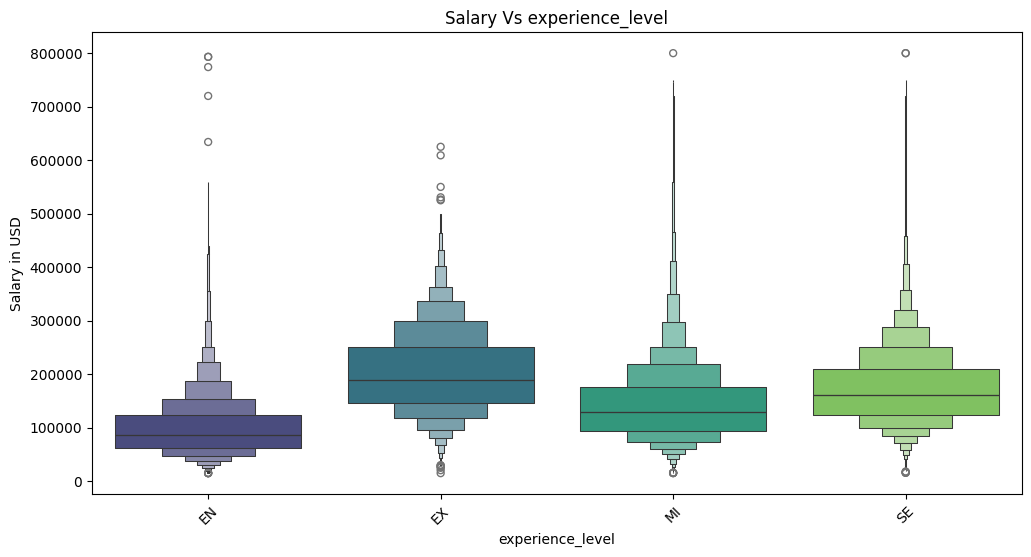

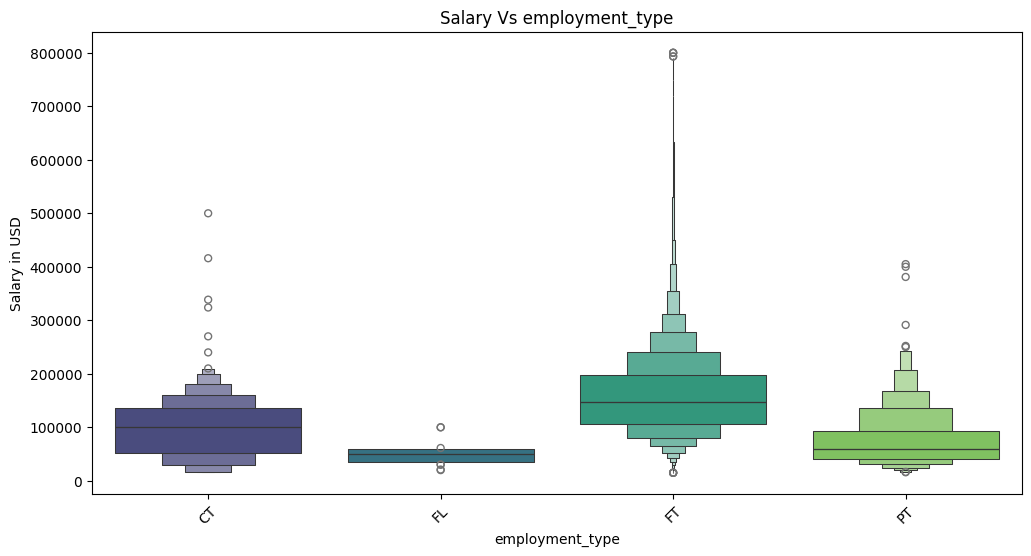

In [15]:

def box_plot(df):
    categorical_cols = ['work_status','experience_level','employment_type']
    for col in categorical_cols:
        plt.figure(figsize=(12, 6))
        sns.boxenplot(data=df, x=col, y='salary_in_usd', palette='viridis')
        plt.title(f'Salary Vs {col}')
        plt.xlabel(col)
        plt.ylabel('Salary in USD')
        plt.xticks(rotation=45)
        plt.show()
box_plot(df)

In [22]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,work_status,company_location,company_size
0,2025,MI,FT,Data Scientist,132600,USD,132600,US,Remote,US,M
1,2025,MI,FT,Data Scientist,102000,USD,102000,US,Remote,US,M
2,2025,SE,FT,Data Product Manager,260520,USD,260520,US,Onsite,US,M
3,2025,SE,FT,Data Product Manager,140280,USD,140280,US,Onsite,US,M
4,2025,SE,FT,Machine Learning Engineer,215000,USD,215000,US,Onsite,US,M


Text(0.5, 1.0, 'Distribution of Salaries')

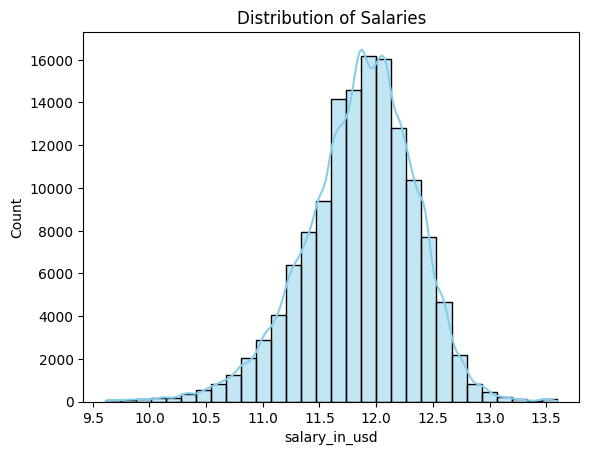

In [35]:
# generate histogram with kde
sns.histplot(np.log1p(df['salary_in_usd']), kde=True, bins=30, color='skyblue')
plt.title('Distribution of Salaries')